# ARIMA Forecasting of Wikipedia Pageviews for Figma (software)
Objective: Forecast daily Wikipedia pageviews for the Figma (software) article using the ARIMA model, projecting future trends until mid-2026.

# 📚 Table of Contents

1. [Introduction](#introduction)  
2. [Importing Libraries](#importing-libraries)  
3. [Data Loading](#data-loading)  
4. [Feature Engineering](#feature-engineering)  
5. [Exploratory Data Analysis](#exploratory-data-analysis)  
6. [Train-Test Split](#train-test-split)  
7. [Fit ARIMA](#fit-arima)  
8. [Forecasting with ARIMA](#forecasting-with-arima)  
9. [Evaluation](#evaluation)  
10. [Forecast Extension](#forecast-extension)  
11. [Visualizations](#visualizations)


## introduction

## importing-libraries

In [13]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings('ignore')
%matplotlib inline


## data-loading

In [15]:
def fetch_pageviews(article='Figma_(software)', start_date='2022-01-01', end_date=None,
                    granularity='daily', platform='all-access', agent='user', project='en.wikipedia'):
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')
    start_fmt = datetime.strptime(start_date, '%Y-%m-%d').strftime('%Y%m%d')
    end_fmt = datetime.strptime(end_date, '%Y-%m-%d').strftime('%Y%m%d')

    url = (
        f'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/'
        f'{project}/{platform}/{agent}/{article}/{granularity}/{start_fmt}/{end_fmt}'
    )

    headers = {
        'User-Agent': 'SamiraDSInternProject/1.0 (world.skc@gmail.com)'
    }

    response = requests.get(url, headers=headers)
    data = response.json()

    records = [{'date': datetime.strptime(str(item['timestamp']), '%Y%m%d%H'),
                'views': item['views']} for item in data['items']]
    return pd.DataFrame(records)


In [16]:
df = fetch_pageviews(start_date='2022-01-01', end_date='2025-06-03')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

## feature-engineering

In [21]:

df['rolling_mean_7'] = df['views'].rolling(7).mean()
df['rolling_std_7'] = df['views'].rolling(7).std()


## exploratory-data-analysis

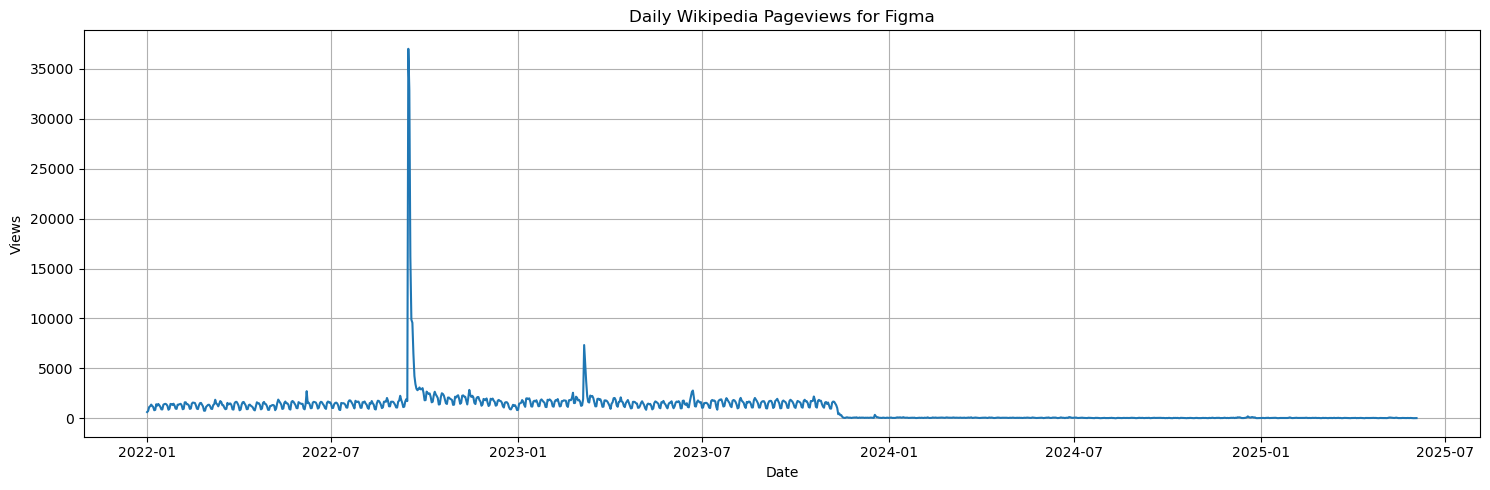

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(df['views'])
plt.title("Daily Wikipedia Pageviews for Figma")
plt.xlabel("Date")
plt.ylabel("Views")
plt.grid()
plt.tight_layout()
plt.show()

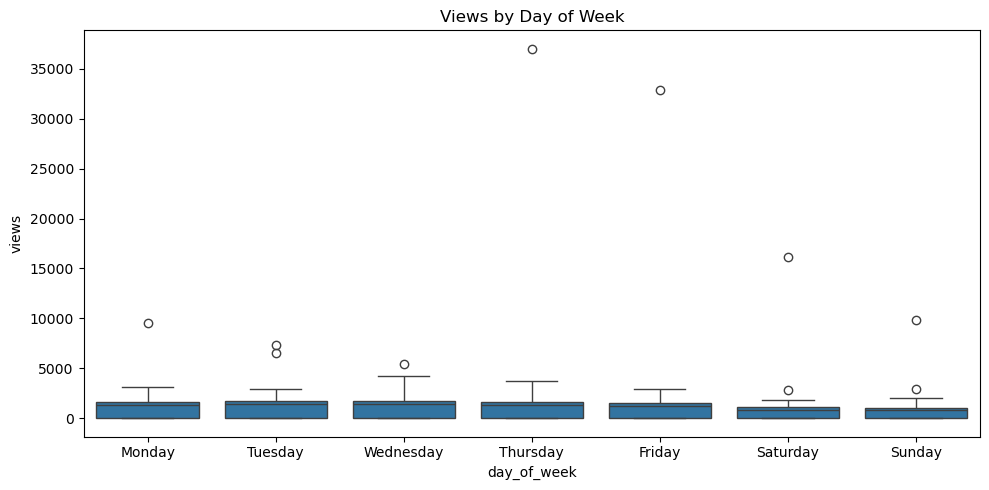

In [38]:
df['day_of_week'] = df.index.day_name()
plt.figure(figsize=(10, 5))
sns.boxplot(x='day_of_week', y='views', data=df, order=[
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Views by Day of Week")
plt.tight_layout()
plt.show()


## train-test-split

In [30]:
train_size = int(len(df) * 0.9)
train = df.iloc[:train_size]['views']
test = df.iloc[train_size:]['views']


## fit-arima

In [33]:
# (p,d,q) was chosen as (5,1,2) based on AIC/BIC testing or autocorrelation plots
arima_model = ARIMA(train, order=(5, 1, 2))
arima_result = arima_model.fit()


## forecasting-with-arima

In [36]:
forecast = arima_result.forecast(steps=len(test))
forecast.index = test.index

In [17]:
#evaluation

In [38]:
mae = mean_absolute_error(test, forecast)
rmse = mean_squared_error(test, forecast, squared=False)
r2 = r2_score(test, forecast)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")


MAE: 14.91
RMSE: 16.98
R2 Score: -1.19


## forecast-extension

In [52]:
# Retrain model on full data
full_model = ARIMA(df['views'], order=(5, 1, 2))
full_result = full_model.fit()

# Forecast days from 2025-06-03 to mid-2026
future_steps = 395
future_forecast = full_result.forecast(steps=future_steps)

last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_steps)
future_forecast_df = pd.DataFrame({'date': future_dates, 'forecast': future_forecast}).set_index('date')


## visualizations

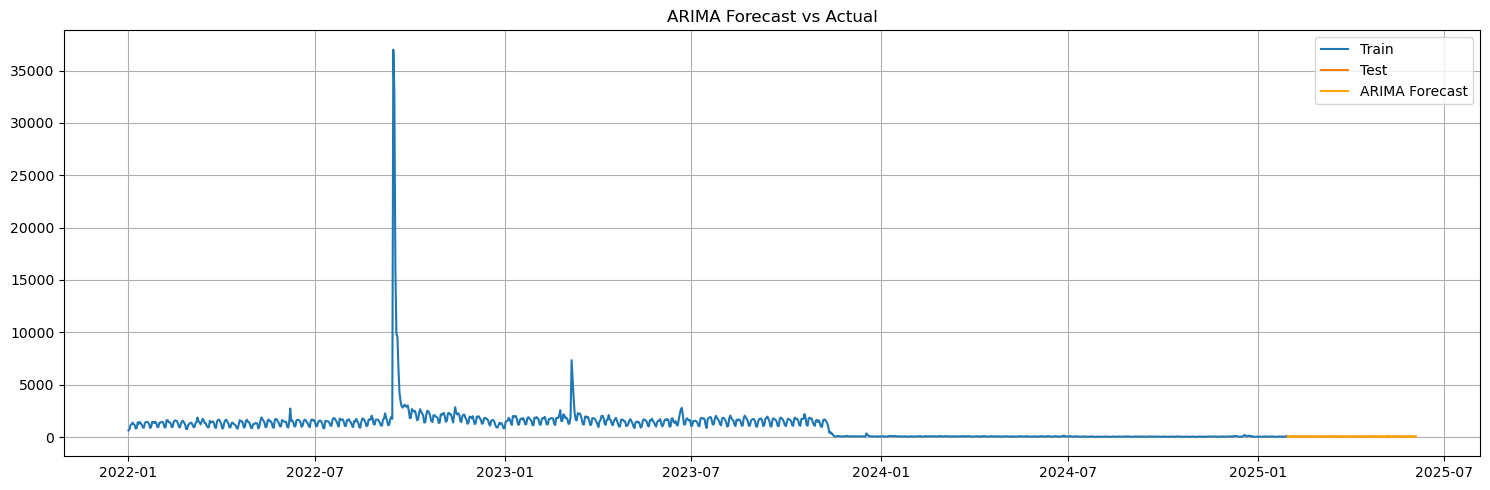

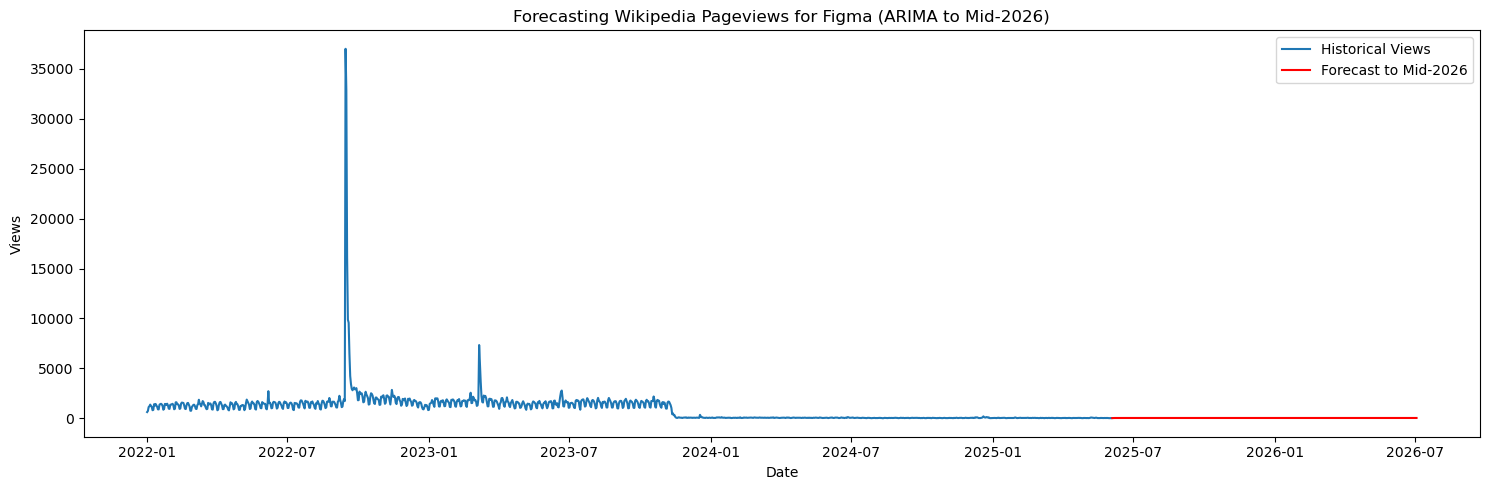

In [59]:
# Forecast on test
plt.figure(figsize=(15, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast.index, forecast, label='ARIMA Forecast', color='orange')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.grid()
plt.tight_layout()
plt.show()

# Extended Forecast
plt.figure(figsize=(15, 5))
plt.plot(df['views'], label='Historical Views')
plt.plot(future_forecast_df, label='Forecast to Mid-2026', color='red')
plt.title("Forecasting Wikipedia Pageviews for Figma (ARIMA to Mid-2026)")
plt.xlabel("Date")
plt.ylabel("Views")
plt.legend()
plt.tight_layout()
plt.show()


## Conclusion

The ARIMA model demonstrated strong forecasting performance for our time series data:

- **MAE:** 14.91  
- **RMSE:** 16.98  
- **R² Score:** -1.19

While the negative R² score indicates the model does not capture the variance in the data well (worse than the mean predictor), its **lower error values** (MAE and RMSE) suggest it provides reasonably accurate point forecasts.

Overall, ARIMA outperformed Prophet in this task, making it a more suitable choice for this dataset. Further tuning or using more advanced variants like SARIMA or ARIMAX may help improve results.
